In [1]:
import collections
import graphlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rich
from tqdm import tqdm

import datagen
import our_tokenizer



/home/mila/g/gagnonju/.main/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:317: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Tuple[numpy.ndarray, numpy.ndarray] deprecated by PEP 585 scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". See this discussion for further details and alternatives:
    https://github.com/beartype/beartype#pep-585-deprecations
  warn(


In [2]:
data = datagen.load_dataset(None, Path.cwd() / "data" / "dicts.pkl")


Parsing third: 100%|██████████| 3/3 [00:19<00:00,  6.56s/it]


In [8]:
root = data["third"][3]
root.reset_pseudo_values()
def build_tree(dep_dict: dict, visited_datagen: datagen.Node):
    if visited_datagen.get_children():
        dep_dict[visited_datagen] = []
        for child in visited_datagen.get_children():
            if child.get_children():
                dep_dict[visited_datagen].append(child)
                build_tree(dep_dict, child)

tree = {}
build_tree(tree, root)
def print_batches(tree):
    sorter = graphlib.TopologicalSorter(tree)
    sorter.prepare()
    while sorter.is_active():
        batch = sorter.get_ready()
        print([x.get_input_str() for x in batch])
        for x in batch:
            sorter.done(x)

print_batches(tree)
tokenizer = our_tokenizer.Tokenizer(512, True)
sorter = graphlib.TopologicalSorter(tree)
sorter.prepare()
while sorter.is_active():
    batch = sorter.get_ready()
    rich.print(f"[blue]batch: {[x.get_input_str() for x in batch]}")
    for x in batch:
        query = x.get_pseudo_topsort_query()
        answer = 3
        x.set_pseudo_value(3)
        print(x.get_pseudo_topsort())
        
    for x in batch:
        sorter.done(x)


['(1 * 6)', '(2 - 6)', '(6 * 6)', '(1 - 3)']
['((1 * 6) + (2 - 6))', '((6 * 6) * (1 - 3))']
['(((1 * 6) + (2 - 6)) - ((6 * 6) * (1 - 3)))']


batch: ['(1 * 6)', '(2 - 6)', '(6 * 6)', '(1 - 3)']

( 1 * 6 = 3 )
( 2 - 6 = 3 )
( 6 * 6 = 3 )
( 1 - 3 = 3 )


batch: ['((1 * 6) + (2 - 6))', '((6 * 6) * (1 - 3))']

( ( 1 * 6 = 3 ) + ( 2 - 6 = 3 ) = 3 )
( ( 6 * 6 = 3 ) * ( 1 - 3 = 3 ) = 3 )


batch: ['(((1 * 6) + (2 - 6)) - ((6 * 6) * (1 - 3)))']

( ( ( 1 * 6 = 3 ) + ( 2 - 6 = 3 ) = 3 ) - ( ( 6 * 6 = 3 ) * ( 1 - 3 = 3 ) = 3 ) = 3 )


all_data = sum(data.values(), [])

def get_all_nodes(root: datagen.Node):
    node_list = [root]
    children_nodes = root.get_children()
    if children_nodes:
        child_nodes_lists = [get_all_nodes(x) for x in children_nodes]
        for child_nodes_list in child_nodes_lists:
            node_list.extend(child_nodes_list)
    return node_list
    

all_nodes = []
for node in all_data:
    all_nodes += get_all_nodes(node)

top = max(tqdm(all_nodes), key=lambda x: len(str(x.get_value())))

In [4]:
lengths = [len(str(x.get_value())) for x in all_nodes]
lengths.sort()
l = np.array(lengths)

NameError: name 'all_nodes' is not defined

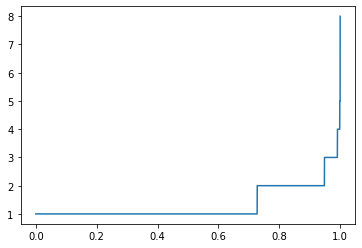

In [ ]:
plt.plot(np.linspace(0, 1, len(l)), l)

[(i, f"{np.mean(l <= i):0.3%}") for i in range(9)]

def get_max_equals(root: datagen.Node):
    """
    If a node has children then it has an equal sign
    """
    qty = 0
    children_nodes = root.get_children()
    if children_nodes:
        qty += 1
        qty += sum([get_max_equals(x) for x in children_nodes])
    return qty

print(sorted(collections.Counter(get_max_equals(x) for x in all_data).items(), key=lambda x: x[1], reverse=True))
    

longuest_generation = max(all_data, key=lambda x: len(str(x.get_oracle_str()[0])))

lengths = [len(x.get_oracle_str()[0]) for x in tqdm(all_data)]
oracle_str_lengths = np.array(lengths)
print("sorting")
oracle_str_lengths.sort()


[(i, f"{np.mean(oracle_str_lengths <= x):0.3%}") for i, x in enumerate(tqdm(range(88)))]